In [1]:
import os
import pickle

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import tqdm
from torch.nn import functional as fnn
from torch.utils import data
from torchvision import transforms

from hack_utils import ScaleMinSideToSize, CropCenter, TransformByKeys
from hack_utils import ThousandLandmarksDataset
from hack_utils import restore_landmarks_batch, create_submission
from hack_utils import stqdm

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DATA_DIR = '../data/'
LOCAL_DATA_DIR = '/work/local_data/made_cv/contest1'

In [3]:
GPUs = [0, 1, 2]

In [4]:
NUM_PTS = 971
CROP_SIZE = 128
BATCH_SIZE = 256 * len(GPUs)
NUM_WORKERS = 16

In [5]:
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [6]:
train_transforms = transforms.Compose([
    ScaleMinSideToSize((CROP_SIZE, CROP_SIZE)),
    CropCenter(CROP_SIZE),
    TransformByKeys(transforms.ToPILImage(), ("image",)),
    TransformByKeys(transforms.ToTensor(), ("image",)),
#     TransformByKeys(transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]), ("image",)),
])

In [7]:
train_dataset = ThousandLandmarksDataset(os.path.join(LOCAL_DATA_DIR, 'train'), train_transforms, split="train")
train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=True,
                                   shuffle=False, drop_last=False)

Total lines (without header): 393930
Loading train dataset (315144 lines)


In [8]:
N_CHANNELS = 3

mean = torch.zeros(N_CHANNELS)
std = torch.zeros(N_CHANNELS)

for batch in stqdm(train_dataloader, total=len(train_dataloader)):
    images = batch["image"]
    for i in range(N_CHANNELS):
        mean[i] += images[:,i,:,:].mean()
        std[i] += images[:,i,:,:].std()

In [9]:
mean.div_(len(train_dataloader))
std.div_(len(train_dataloader))
print(mean, std)

tensor([0.4782, 0.3758, 0.3278]) tensor([0.3058, 0.2633, 0.2502])


In [10]:
import pandas as pd

In [11]:
landmarks = pd.read_csv(os.path.join(LOCAL_DATA_DIR, 'train/landmarks.csv'), sep='\t')

In [12]:
landmarks.head()

,file_name,Point_0_X,Point_0_Y,Point_1_X,Point_1_Y,Point_2_X,Point_2_Y,Point_3_X,Point_3_Y,Point_4_X,...,Point_966_X,Point_966_Y,Point_967_X,Point_967_Y,Point_968_X,Point_968_Y,Point_969_X,Point_969_Y,Point_970_X,Point_970_Y
0,07c5e48d938e8d82c0f10973d66183f3.jpg,162,311,159,311,156,311,152,311,149,...,125,254,124,254,123,254,112,163,191,166
1,1daf2e7328d121ec280c08f62926e2f9.jpg,136,288,133,288,131,287,128,287,125,...,108,224,106,223,106,223,108,147,191,156
2,98d5186671bbcb31a79a16878a57de77.jpg,113,212,111,212,109,212,106,212,104,...,106,172,105,172,105,172,111,108,143,120
3,12434863c3a9d9b8b3b0889a4d08d340.jpg,119,237,117,236,115,235,113,235,111,...,124,201,123,201,123,200,143,142,182,149
4,28e70684d6e2d6d75a6d3a973e4d4d93.jpg,89,376,88,375,86,374,84,373,82,...,86,308,84,309,85,309,97,203,162,202


In [13]:
pd.isnull(landmarks).any().any()

False

In [14]:
landmarks.filter(like='Point').min().min()

-22

In [15]:
landmarks.filter(like='Point').max().max()

1308

In [16]:
landmarks.describe()

,Point_0_X,Point_0_Y,Point_1_X,Point_1_Y,Point_2_X,Point_2_Y,Point_3_X,Point_3_Y,Point_4_X,Point_4_Y,...,Point_966_X,Point_966_Y,Point_967_X,Point_967_Y,Point_968_X,Point_968_Y,Point_969_X,Point_969_Y,Point_970_X,Point_970_Y
count,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,...,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000,393930.000000
mean,109.239306,234.331851,107.262011,234.277796,105.289473,234.139634,103.329835,233.898363,101.393687,233.545955,...,88.832166,189.382177,87.499139,188.961003,87.385292,188.686256,81.169627,126.703191,135.815188,125.638240
std,56.067140,108.138185,55.205913,108.114235,54.339303,108.056016,53.466530,107.955335,52.589330,107.809149,...,44.864228,88.498203,44.261331,88.356099,44.211072,88.281223,40.795430,59.825748,65.684533,59.611564
min,12.000000,73.000000,11.000000,73.000000,10.000000,73.000000,9.000000,73.000000,8.000000,73.000000,...,18.000000,61.000000,17.000000,60.000000,17.000000,60.000000,17.000000,32.000000,37.000000,30.000000
25%,69.000000,152.000000,68.000000,152.000000,66.000000,152.000000,65.000000,152.000000,64.000000,152.000000,...,56.000000,122.000000,55.000000,122.000000,55.000000,122.000000,51.000000,81.000000,87.000000,81.000000
50%,94.000000,204.000000,92.000000,204.000000,90.000000,203.000000,89.000000,203.000000,87.000000,203.000000,...,76.000000,164.000000,75.000000,164.000000,75.000000,164.000000,70.000000,110.000000,117.000000,109.000000
75%,134.000000,286.000000,132.000000,286.000000,130.000000,286.000000,127.000000,285.000000,125.000000,285.000000,...,109.000000,231.000000,107.000000,231.000000,107.000000,230.000000,100.000000,155.000000,166.000000,154.000000
max,714.000000,1297.000000,709.000000,1300.000000,704.000000,1302.000000,699.000000,1304.000000,693.000000,1306.000000,...,570.000000,1054.000000,568.000000,1053.000000,568.000000,1052.000000,467.000000,671.000000,755.000000,640.000000


In [17]:
indices_with_negative_coordinates = np.where((landmarks.filter(like='Point') < 0).any(axis=1))[0]
len(indices_with_negative_coordinates)

35

In [18]:
def draw_landmarks(image, landmarks):
    image = image.copy()
    landmarks = landmarks.reshape(-1, 2)
    for point in landmarks:
        x, y = point.astype(np.int)
        cv2.circle(image, (x, y), 1, (128, 0, 128), 1, -1)
    return image

In [19]:
landmarks.iloc[indices_with_negative_coordinates].file_name.head()

18445    ab789a1de92b1fa6695bc40177db9610.jpg
23142    37e2df4075abe0d0b9c6c0af80ea1a1a.jpg
24943    6bb5989cfb57f9016688b16479e76b0b.jpg
26884    af1281f3e87c800f1df1308545e06697.jpg
53589    ec84da71ab79915b5462273832e62848.jpg
Name: file_name, dtype: object

In [20]:
i = 0
idx = indices_with_negative_coordinates[i]
idx_landmarks = landmarks.iloc[idx, 1:].values.astype(np.int16)

In [21]:
imgname = landmarks.at[idx, 'file_name']
imgpath = os.path.join(LOCAL_DATA_DIR, 'train/images', imgname)
imgpath

'/work/local_data/made_cv/contest1/train/images/ab789a1de92b1fa6695bc40177db9610.jpg'

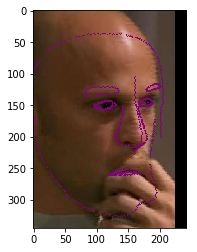

In [22]:
image = cv2.imread(imgpath)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = draw_landmarks(image, idx_landmarks)

plt.imshow(image)